In [1]:
import numpy as np
import os
import tqdm
import matplotlib.pyplot as plt
import math
import cv2
import skimage
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torch.utils.data.dataset import Dataset
from torchvision import datasets, models, transforms
import torchvision.transforms.functional as TF
import random
import time
import copy
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image

def extractFrame(mp4Dir):
    vid = cv2.VideoCapture(mp4Dir)
    allFrame = []
    while vid.isOpened():
        ret,frame = vid.read()
        if ret:
            dimx,dimy = frame.shape[:2]
            allFrame.append(frame[int(dimx*.5):int(dimx*.8),
                                 int(dimy*.3):int(dimy*.7)])
        else:
            break
    return np.array(allFrame)
def extractYellowMask(allFrame):
    copyFrame = allFrame.copy()
    hsv_y1 = np.asarray([20, 100, 100])   
    hsv_y2 = np.asarray([30, 255, 255])   # yellow! note the order
    maskYellow = []
    for i in range(len(copyFrame)):
        hsv = cv2.cvtColor(copyFrame[i], cv2.COLOR_BGR2HSV)
        masky = cv2.inRange(hsv, hsv_y1, hsv_y2)
        maskYellow.append(masky)
    return maskYellow
def extractYellow(img):
    hsv = cv2.cvtColor(img[:,:,::-1], cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, (20, 100, 100), (30, 255, 255))
    ## slice the yellow
    imask = mask>0
    return np.sum(imask)/len(imask.flatten())
def extractGreen(img):
    hsv = cv2.cvtColor(img[:,:,::-1], cv2.COLOR_BGR2HSV)
#     mask = cv2.inRange(hsv, (36, 25, 25), (86, 255,255))
    mask = cv2.inRange(hsv, (36, 25, 25), (70, 255,255))
    ## slice the green
    imask = mask>0
    return np.sum(imask)/len(imask.flatten())
def extractRed(img):
    hsv = cv2.cvtColor(img[:,:,::-1], cv2.COLOR_BGR2HSV)
    maskr1 = cv2.inRange(hsv, (0,50,20), (5,255,255))
    maskr2 = cv2.inRange(hsv, (175,50,20), (180,255,255))
    maskr = cv2.bitwise_or(maskr1, maskr2)
    imask = maskr>0
    return np.sum(imask)/len(imask.flatten())
def preprocessingexcel():
    dfs = pd.read_excel("D:/DreamAI/scan-cards-processed.xlsx",
                       header=None)
    dfs.drop(dfs.tail(1).index,inplace=True)
    del dfs[4]
    return dfs
def getMidLastYellowFrame(dataframe):
    allDIR = 'D:/DreamAI/table'
    allTableID = os.listdir(allDIR)
    cropUVPix = np.array([[40,90,110,290],[32,80,110,290],[35,80,110,290],
                     [35,80,115,295],[37,80,115,295],[35,80,110,290],
                     [35,80,110,290],[35,80,110,290],[35,80,105,295],
                     [35,80,110,295],[40,80,115,300],[35,80,115,300],
                     [35,80,115,300],[30,80,115,300],[40,90,110,290],
                     [35,85,110,295],[45,80,110,295],[37,70,110,295]])
    
    allLast,allMid,allYellow = [],[],[]
    allLabels = []
    for i in tqdm.tqdm(range(len(allTableID))):
        tmpath = os.path.join(allDIR,allTableID[i])
        tmpvidID = os.listdir(tmpath)
        xi,xf,yi,yf = cropUVPix[i]
        for j in tmpvidID:
            tmpvidpath = os.path.join(tmpath,j)
            allFrame = extractFrame(tmpvidpath)
            noF = len(allFrame)
            maskYellow=extractYellowMask(allFrame[:,xi:xf,yi:yf,:].copy())
            allLast.append(allFrame[-1][xi:xf,yi:yf,::-1].copy())
            allMid.append(allFrame[int(noF/2)][xi:xf,yi:yf,::-1].copy())
            allYellow.append(np.mean(maskYellow[:int(noF*.4)],axis=0))
            
            tmpvidIDnew = j.replace('.mp4','')
            tmpstr = dataframe.loc[dataframe[0]==int(tmpvidIDnew),3].values[0]
            tmpstr2 = tmpstr.split(';')
            allcardID = []
            for k in range(len(tmpstr2)):
                tmpstr3 = tmpstr2[k].split(':')
                if int(tmpstr3[1])%13 >= 9:
                    allcardID.append(str(9))
                else:
                    allcardID.append(str(int(tmpstr3[1])%13))
            allLabels.append(allcardID)
    return np.array(allLast),np.array(allMid),allYellow,allLabels
def separateAreas(Last,Yellow):
    xall,yall = np.where(Yellow>200) 
    xi,xf,yi,yf = xall.min(),xall.max(),yall.min(),yall.max()
    Upper = Last[:xf+5,:,:].copy()
    Lower = Last[xf+5:,:,:].copy()
    yLen = Last.shape[1]
    # Area 1: Top left, Area 2: Top right, Area 3: Bottom left
    # Area 4: Bottom Right
    Area1 = Upper[:,:int(yLen/2)-7,:].copy()
    Area2 = Upper[:,int(yLen/2)+7:,:].copy()
    Area3 = Lower[:,:int(yLen/2)-7,:].copy()
    Area4 = Lower[:,int(yLen/2)+7:,:].copy()
    return Area1,Area2,Area3,Area4
def detectExtraCard(frameTL,frameTR):
    threshL,threshR = .56,.7
    RGa1 = extractGreen(frameTL)+extractRed(frameTL)
    YGa2 = extractGreen(frameTR)+extractYellow(frameTR)
    return RGa1<=threshL,YGa2<=threshR
def cutoffGRYLR(frame,mode,thresh=.8): # cut off yellow,red,green
    # mode 1: cut green, mode 2: cut red and green
    # mode 3: cut yellow and green
    profileLR,profileRL = [],[]
    tmp = frame.copy()
    for i in range(tmp.shape[1]):
        tmpval = extractGreen(tmp[:,:i+1,::-1])
        if mode == 2:
            tmpval += extractRed(tmp[:,:i+1,::-1])
        elif mode == 3:
            tmpval += extractYellow(tmp[:,:i+1,::-1])
        profileLR.append(tmpval)
    profileLR = np.array(profileLR)
    for i in range(tmp.shape[1]):
        tmpval = extractGreen(tmp[:,-(i+1):,::-1])
        if mode == 2:
            tmpval += extractRed(tmp[:,:i+1,::-1])
        elif mode == 3:
            tmpval += extractYellow(tmp[:,:i+1,::-1])
        profileRL.append(tmpval)
    profileRL = np.array(profileRL)
    
    try:
        leftix = profileLR[profileLR>thresh].argmin()
    except:
        leftix = []
    
    try:
        rightix = profileRL[profileRL>thresh].argmin()
    except:
        rightix = []
    
    if leftix and rightix:
        result = tmp[:,leftix+1:-(rightix+1),:]
    elif not leftix and rightix:
        result = tmp[:,:-(rightix+1),:]
    elif leftix and not rightix:
        result = tmp[:,leftix+1:,:]
    elif not leftix and not rightix:
        result = tmp
    return result
def extractAllCards(Last,Yellow):
    a1,a2,a3,a4 = separateAreas(Last,Yellow)
    Card4Bol,Card5Bol = detectExtraCard(a1,a2)
    Card4 = cutoffGRYLR(a1,mode=2,thresh=.7)
    Card5 = cutoffGRYLR(a2,mode=2,thresh=.7)
    BL,BR = cutoffGRYLR(a3,mode=1),cutoffGRYLR(a4,mode=1)
    dyBL,dyBR = BL.shape[1],BR.shape[1]
    Card0,Card1=a3[:,:int(dyBL/2)+5,:],a3[:,int(dyBL/2)+10:,:]
    Card2,Card3=a4[:,:int(dyBR/2)+5,:],a4[:,int(dyBR/2)+10:,:]
    return Card0,Card1,Card2,Card3,Card4,Card5,Card4Bol,Card5Bol
def rearrangeData(allLast,allYellow,allLabel):
    cardsCollection,labelsCollection = [],[]
    for ix in range(len(allLast)):
        c0,c1,c2,c3,c4,c5,c4bol,c5bol=extractAllCards(allLast[ix],
                                            allYellow[ix])
        for i in range(4):
            exec('cardsCollection.append(c{})'.format(i))
            exec('labelsCollection.append(allLabel[ix][{}])'.format(i))    
        cardsCollection.append(c4);cardsCollection.append(c5)
        if c4bol and c5bol:
            labelsCollection.append(allLabel[ix][4])
            labelsCollection.append(allLabel[ix][5])
        elif c4bol and not c5bol:
            labelsCollection.append(allLabel[ix][4])
            labelsCollection.append('10')
        elif not c4bol and c5bol:
            labelsCollection.append('10')
            labelsCollection.append(allLabel[ix][4])
        elif not c4bol and not c5bol:
            labelsCollection.append('10')
            labelsCollection.append('10')     
    return cardsCollection,labelsCollection

In [2]:
dfs = preprocessingexcel()
allLast,allMid,allYellow,allLabel = getMidLastYellowFrame(dfs)
cardsCollection,labelsCollection = rearrangeData(allLast,allYellow,allLabel)

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [01:06<00:00,  4.13s/it]


In [3]:
cardsCollection = np.array(cardsCollection)
labelsCollection =  np.array(labelsCollection)

In [4]:
print(len(cardsCollection),len(labelsCollection)) # sanity check

192 192


In [5]:
np.unique(labelsCollection)

array(['0', '1', '10', '2', '3', '4', '5', '6', '7', '8', '9'],
      dtype='<U2')

In [6]:
len(np.unique(labelsCollection))

11

#### Transfer Learning part

In [7]:
class MyRotationTransform:
    """Rotate by one of the given angles."""

    def __init__(self, angles):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)
        return TF.rotate(x, angle)

rotation_transform = MyRotationTransform(angles=[-90, 0, 90, 180])

In [8]:
transformations = transforms.Compose([
        transforms.Resize((224,224)), 
        rotation_transform,
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

9


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


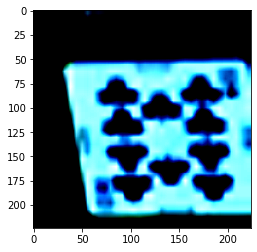

In [9]:
print(int(labelsCollection[0]))
tmp = Image.fromarray(cardsCollection[0][:,:,::-1])
plt.imshow(np.transpose(transformations(tmp).numpy(),(2,1,0)))

In [10]:
class CustomDatasetFrom(Dataset): # input np arrays
    def __init__(self,nparray,labarray,nblabels,transform=None):
        self.data = nparray
        self.label = labarray
        self.nlabels = nblabels
        self.transforms = transform
    def __getitem__(self,index):
        img_as_np = self.data[index]
        img_as_img = Image.fromarray(img_as_np)
        if self.transforms is not None:
            img_as_tensor = self.transforms(img_as_img)
        
        y=torch.tensor(np.array([[int(self.label[index])]]),dtype=torch.long)   
        
        return img_as_tensor, y
    def __len__(self):
        return self.data.shape[0]

Since the cardCollection array has image arrays with different sizes, in the transform resize part, we need to specify both dimensions from 224 to (224,224).

In [11]:
nb_labels = 11

In [12]:
custom_data_from_nparr=CustomDatasetFrom(cardsCollection,labelsCollection,
                                         nb_labels ,transformations)
dataloaders = torch.utils.data.DataLoader(custom_data_from_nparr, batch_size=4,
                                    shuffle=True, num_workers=0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
validation_split = .05

# Creating data indices for training and validation splits:
dataset_size = len(custom_data_from_nparr)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(custom_data_from_nparr, batch_size=4, 
                                          sampler=train_sampler, num_workers=0)
validation_loader = torch.utils.data.DataLoader(custom_data_from_nparr, batch_size=4,
                                          sampler=valid_sampler, num_workers=0)


In [82]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataload = train_loader
                datasize = len(train_loader)
            else:
                model.eval()   # Set model to evaluate mode
                dataload = validation_loader
                datasize = len(validation_loader)

            running_loss = 0.0
            running_corrects = 0
            running_exp = 0
            # Iterate over data.
            for inputs, labels in tqdm.tqdm(dataload):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    target = labels.squeeze()
                    if not target.size():
                        target = labels.view(-1)
                    loss = criterion(outputs, target)                    

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == target.data)
                running_exp += torch.sum(preds == preds)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / running_exp.double()
            epoch_acc = running_corrects.double() / running_exp.double()

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [84]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to (num of classes)
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, nb_labels)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:03<00:00, 14.10it/s]


train Loss: 1.9208 Acc: 0.3989


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 41.72it/s]


val Loss: 0.5871 Acc: 0.7778

Epoch 1/9
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:03<00:00, 14.05it/s]


train Loss: 1.3313 Acc: 0.5902


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 41.72it/s]


val Loss: 0.2771 Acc: 0.8889

Epoch 2/9
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:03<00:00, 13.97it/s]


train Loss: 1.0443 Acc: 0.6393


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 41.72it/s]


val Loss: 0.2946 Acc: 0.8889

Epoch 3/9
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:03<00:00, 14.05it/s]


train Loss: 0.7190 Acc: 0.7650


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 39.53it/s]


val Loss: 0.1227 Acc: 0.8889

Epoch 4/9
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:03<00:00, 14.15it/s]


train Loss: 0.8143 Acc: 0.7486


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 35.76it/s]


val Loss: 0.2352 Acc: 0.8889

Epoch 5/9
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:03<00:00, 14.06it/s]


train Loss: 0.5823 Acc: 0.8415


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 44.18it/s]


val Loss: 0.3019 Acc: 0.8889

Epoch 6/9
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:03<00:00, 14.17it/s]


train Loss: 0.5028 Acc: 0.8306


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 44.18it/s]


val Loss: 0.0281 Acc: 1.0000

Epoch 7/9
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:03<00:00, 14.15it/s]


train Loss: 0.3875 Acc: 0.9016


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 39.53it/s]


val Loss: 0.0308 Acc: 1.0000

Epoch 8/9
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:03<00:00, 14.08it/s]


train Loss: 0.2804 Acc: 0.9180


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 41.72it/s]


val Loss: 0.0675 Acc: 1.0000

Epoch 9/9
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:03<00:00, 14.04it/s]


train Loss: 0.2856 Acc: 0.9344


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 42.57it/s]


val Loss: 0.0553 Acc: 1.0000

Training complete in 0m 34s
Best val Acc: 1.000000


In [85]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:03<00:00, 14.60it/s]


train Loss: 0.3986 Acc: 0.8907


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 45.06it/s]


val Loss: 0.0551 Acc: 1.0000

Epoch 1/9
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:03<00:00, 14.61it/s]


train Loss: 0.2968 Acc: 0.9180


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 44.18it/s]


val Loss: 0.0298 Acc: 1.0000

Epoch 2/9
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:03<00:00, 14.77it/s]


train Loss: 0.1953 Acc: 0.9781


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 41.72it/s]


val Loss: 0.0521 Acc: 1.0000

Epoch 3/9
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:03<00:00, 14.80it/s]


train Loss: 0.2064 Acc: 0.9672


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 41.72it/s]


val Loss: 0.0432 Acc: 1.0000

Epoch 4/9
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:03<00:00, 14.65it/s]


train Loss: 0.3105 Acc: 0.9344


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 44.18it/s]


val Loss: 0.0314 Acc: 1.0000

Epoch 5/9
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:03<00:00, 14.66it/s]


train Loss: 0.1989 Acc: 0.9563


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 43.33it/s]


val Loss: 0.0385 Acc: 1.0000

Epoch 6/9
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:03<00:00, 14.43it/s]


train Loss: 0.2578 Acc: 0.9290


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 41.72it/s]


val Loss: 0.0346 Acc: 1.0000

Epoch 7/9
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:03<00:00, 14.53it/s]


train Loss: 0.2590 Acc: 0.9454


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 41.72it/s]


val Loss: 0.0419 Acc: 1.0000

Epoch 8/9
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:03<00:00, 14.53it/s]


train Loss: 0.3316 Acc: 0.9290


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 46.94it/s]


val Loss: 0.0291 Acc: 1.0000

Epoch 9/9
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:03<00:00, 14.58it/s]


train Loss: 0.1998 Acc: 0.9508


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 45.92it/s]


val Loss: 0.0577 Acc: 1.0000

Training complete in 0m 33s
Best val Acc: 1.000000


Save model

In [86]:
torch.save(model_ft, os.path.join(os.getcwd(),'card1.pt'))

C:\Users\44754\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\44754\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\44754\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\44754\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\4475